# Exporatory Analytics of Dataset

## DS 5110
* Fall 2021
* Group 10
  * Antone Edelman
  * Xin Huang
  * Robert Knuuti

## Data Prep
### Exploration and Preliminary Feature Engineering

In this notebook, we leverage the filtered game dataset from the first notebook and begin to explore elements of the data.

First, we split the algebreic notation of the chess games into an array of moves.
This will help with future analytics to more aptly filter on a specific move in a game.

Next, we more concretely define when a game is a win or a loss.
The field in our source data is one of `1-0`, `0-1`, or `1/2-1/2`.
We define a White win as `1-0`.
We define a Black win as `0-1`.
We define a tie as `1/2-1/2`.
Each of these are created as new columns that match the boolean statement (one hot encoding).

Following this, we establish a total move count and game complexity measure based on the total number of moves in a game.
We bin these features from 1 to 6, where each number increase is 10 more moves than the last.
This will help generalize the overall analysis based on lengths.
It's worth noting that the average game of chess is 37 moves.
This means that if we were to do a density plot of this measure, it should have a crest at 4.

Finally, we create a simplification of the moves array, containing only the first 2 and 10 moves.
This will aid in answering our question on if the moves used in an opening influence the results of our win.

Finally, we minimize our dataframe to the features we believe will have influence in determing what results in a win, saving it to a parquet file for future notebooks to process.

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import seaborn as sns

%matplotlib inline

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("fa21-ds5110-group10-rk") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()

In [2]:
spark.sparkContext

<SparkContext master=local[*] appName=fa21-ds5110-group10-rk>

In [3]:
spark.sparkContext.cancelAllJobs()

In [4]:
df = spark.read.parquet("../../data/processed/chess_games_blitz_classic.parquet")

There's some additional cleanup we have to do beyond the filtering of games to just classic and blitz.
Below are our transforms to add new features and to transform the data.

In [5]:
df.printSchema()

print("Abandoned Games to drop: {}".format(df.filter(F.col("result").contains("*")).count()))
# Remove all abandoned games.
df_filtered = df.filter(~F.col("result").contains("*"))

from fractions import Fraction as frac

# We break apar the AN notation for chess moves into arrays
def movetype(x):
    import re
    moves = re.split('\d+\. ', x)[1:]
    return [x.strip() for x in moves]


udf_movetype = F.udf(lambda x: movetype(x), T.ArrayType(T.StringType()))
df_filtered = df_filtered.withColumn('moves', udf_movetype(F.col('AN')))

# Convert result column into seperate white/black win columns
white_win_udf = F.udf(lambda result: float(frac(result.split('-')[0])), T.DoubleType())
df_filtered = df_filtered.withColumn("white_games_won", white_win_udf(F.col("result")))
black_win_udf = F.udf(lambda result: float(frac(result.split('-')[1])), T.DoubleType())
df_filtered = df_filtered.withColumn("black_games_won", black_win_udf(F.col("result")))
df_filtered = df_filtered.withColumn("tie", F.col("white_games_won") == F.col("black_games_won"))

# Identify the total number of moves in a game
df_filtered = df_filtered.withColumn("result_moves", F.size(F.col("moves")))
# Categorize games based upon total move size.
df_filtered = df_filtered.withColumn("game_complexity",
                                     F.when(F.col("result_moves") ==  1, 1)\
                                      .when(F.col("result_moves") <= 10, 2)\
                                      .when(F.col("result_moves") <= 20, 3)\
                                      .when(F.col("result_moves") <= 30, 4)\
                                      .when(F.col("result_moves") <= 40, 5)\
                                      .when(F.col("result_moves") <= 50, 6)\
                                      .otherwise(7))

df_filtered = df_filtered.withColumn("opening_class",
                                     F.when(F.lower(F.col("ECO")).contains("a"), "Flank openings")\
                                      .when(F.lower(F.col("ECO")).contains("b"), "Semi-Open Games")\
                                      .when(F.lower(F.col("ECO")).contains("c"), "Open Games")\
                                      .when(F.lower(F.col("ECO")).contains("d"), "Semi-Closed Games")\
                                      .when(F.lower(F.col("ECO")).contains("e"), "Indian Defences")\
                                      .otherwise("Other"))



df_filtered = df_filtered.withColumn("EloDiff", F.col("WhiteElo") - F.col("BlackElo"))


# Collect only the first subset of moves in a game
df_filtered = df_filtered.withColumn("first_ten", F.slice(F.col("moves"), 1, 10))
df_filtered = df_filtered.withColumn("first_two", F.slice(F.col("moves"), 1, 2))

# We establish a formal win column that we'll be using as a logistical response
# We will not consider a tie as a win for white.
df_filtered = df_filtered.withColumn("white_result",
                                     F.when(F.col("white_games_won") > 0.5, "win")\
                                      .otherwise("loss"))

print("Refined schema\n-------------------")
df_filtered.printSchema()

root
 |-- event: string (nullable = true)
 |-- white: string (nullable = true)
 |-- black: string (nullable = true)
 |-- result: string (nullable = true)
 |-- UTCDate: date (nullable = true)
 |-- UTCTime: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- AN: string (nullable = true)

Abandoned Games to drop: 739
Refined schema
-------------------
root
 |-- event: string (nullable = true)
 |-- white: string (nullable = true)
 |-- black: string (nullable = true)
 |-- result: string (nullable = true)
 |-- UTCDate: date (nullable = true)
 |-- UTCTime: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: d

In [6]:
df_filtered.describe(['WhiteElo', 'BlackElo']).show()

+-------+------------------+------------------+
|summary|          WhiteElo|          BlackElo|
+-------+------------------+------------------+
|  count|           3849646|           3849646|
|   mean| 1710.584323078018| 1708.761483263656|
| stddev|263.42156710132883|264.54823496140455|
|    min|               762|               728|
|    max|              2906|              2907|
+-------+------------------+------------------+



In [7]:
df_filtered.groupBy(['result']).count().show()

+-------+-------+
| result|  count|
+-------+-------+
|1/2-1/2| 157936|
|    1-0|1913218|
|    0-1|1778492|
+-------+-------+



In [8]:
df_filtered.groupBy(['TimeControl']).count().sort('count', ascending=False).toPandas()

,TimeControl,count
0,300+0,879073
1,180+0,699358
2,600+0,417836
3,900+0,148993
4,180+2,139886
...,...,...
815,5400+25,1
816,2400+16,1
817,60+150,1
818,720+180,1


In [9]:
eco_summary = df_filtered.groupBy(['ECO']).count().sort('count', ascending=False).toPandas()

<AxesSubplot:xlabel='ECO', ylabel='count'>

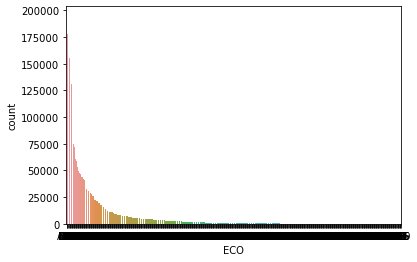

In [10]:
sns.barplot(data=eco_summary, x='ECO', y='count')

<AxesSubplot:xlabel='result_moves'>

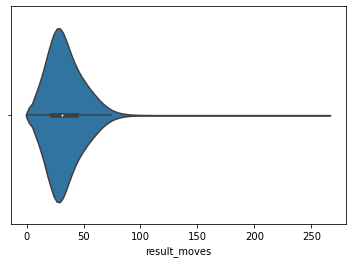

In [11]:
complexity = df_filtered.select(['result_moves']).toPandas()

sns.violinplot(x="result_moves", data=complexity)

In [12]:
complexity = df_filtered.select(['game_complexity']).toPandas()

<AxesSubplot:xlabel='game_complexity', ylabel='count'>

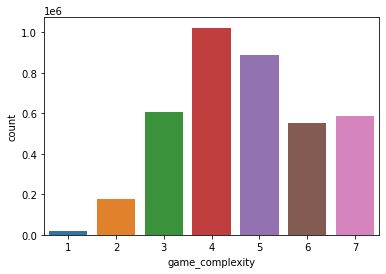

In [13]:
sns.countplot(x="game_complexity", data=complexity)

<AxesSubplot:>

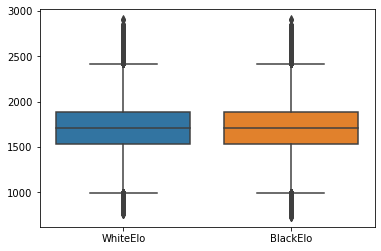

In [14]:
elos = df_filtered.select(['WhiteElo', 'BlackElo']).toPandas()
sns.boxplot(data=elos)

In [15]:
df_filtered.groupBy('opening_class').count().show()

+-----------------+-------+
|    opening_class|  count|
+-----------------+-------+
|       Open Games|1409420|
|Semi-Closed Games| 523908|
|  Semi-Open Games|1052515|
|   Flank openings| 784356|
|  Indian Defences|  79447|
+-----------------+-------+



[None, None, None, None, None]

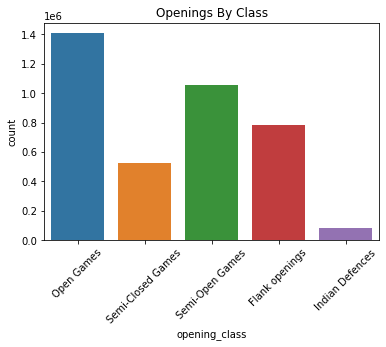

In [16]:
openings_c = df_filtered.groupBy('opening_class').count().toPandas()
openings = sns.barplot(x="opening_class",y="count",data=openings_c)

openings.set_title('Openings By Class')
    
[item.set_rotation(45) for item in openings.get_xticklabels()]

<AxesSubplot:>

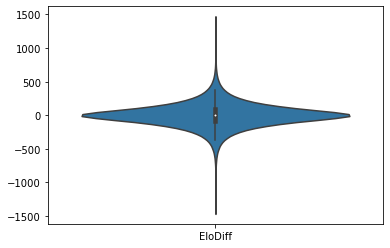

In [17]:
eloDiff = df_filtered.select(['EloDiff']).toPandas()
sns.violinplot(data=eloDiff, cut=0)

In [18]:
vars_to_keep = ["event", 
                "white_result", 
                "first_two",
                "ECO",
                "EloDiff",
                "Opening",
                "game_complexity",
                "opening_class"]

df_filtered.select(vars_to_keep).show(5)

+---------+------------+----------------+---+-------+--------------------+---------------+---------------+
|    event|white_result|       first_two|ECO|EloDiff|             Opening|game_complexity|  opening_class|
+---------+------------+----------------+---+-------+--------------------+---------------+---------------+
|    Blitz|         win|[c4 c5, Nc3 Nf6]|A34|    222|English Opening: ...|              6| Flank openings|
|    Blitz|         win| [d4 b6, c4 Bb7]|A40|    309|  English Defense #2|              5| Flank openings|
|Classical|        loss| [e4 Nc6, d4 d5]|B00|   -248|Nimzowitsch Defen...|              7|Semi-Open Games|
|    Blitz|         win|[e4 e5, d4 exd4]|C21|   -212|       Danish Gambit|              4|     Open Games|
|    Blitz|        loss|[e4 e5, d4 exd4]|C22|     75|Center Game: Paul...|              4|     Open Games|
+---------+------------+----------------+---+-------+--------------------+---------------+---------------+
only showing top 5 rows



In [19]:
# subset the dataframe on these predictors
df_final = df_filtered.select(vars_to_keep)

In [20]:
df_final.write.mode("overwrite").parquet("../../data/processed/chess_games_moves_model.parquet")

Next we split our data for future modeling using a 60, 30, 10 split for training, testing, and validation.

In [21]:
trainData, testData, validationData  = df_final.randomSplit([0.6, 0.3, 0.1], seed=314)

In [22]:
trainData.write.mode("overwrite").parquet("../../data/processed/training.parquet")

In [23]:
testData.write.mode("overwrite").parquet("../../data/processed/testing.parquet")

In [24]:
validationData.write.mode("overwrite").parquet("../../data/processed/validation.parquet")